In [432]:
import re
import pandas as pd
import numpy as np
import os

import gensim
import nltk
from nltk.tokenize.toktok import ToktokTokenizer

from nltk.corpus import stopwords

SEED = 42

import torch
import torch.nn as nn

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

nltk.download('stopwords')
import math
from torch.autograd import Variable
from string import punctuation
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt
from collections import Counter

from sklearn import metrics
from sklearn.model_selection import train_test_split
import gensim.downloader



#from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [433]:
#importing the training data
#imdb_data=pd.read_csv('All_rated_reviews.csv')
imdb_data1 = pd.read_csv('rated_and_not_rated_reviews_1.csv')
imdb_data2 = pd.read_csv('rated_and_not_rated_reviews_2.csv')
imdb_data = pd.concat([imdb_data1, imdb_data2], ignore_index=True)
imdb_data = imdb_data.loc[:, ~imdb_data.columns.str.match('Unnamed')]
print(imdb_data.shape)
imdb_data.head(5)

(37500, 4)


,user_id,rating,label,review
0,0,9.0,positive,Bromwell High is a cartoon comedy. It ran at t...
1,10000,8.0,positive,Homelessness (or Houselessness as George Carli...
2,10001,10.0,positive,Brilliant over-acting by Lesley Ann Warren. Be...
3,10002,7.0,positive,This is easily the most underrated film inn th...
4,10003,8.0,positive,This is not the typical Mel Brooks film. It wa...


In [434]:
#Summary of the dataset
imdb_data.describe()

,rating
count,25000.000000
mean,5.477720
std,3.466477
min,1.000000
25%,2.000000
50%,5.500000
75%,9.000000
max,10.000000


In [435]:
#sentiment count to see that the model is balanced
imdb_data['label'].value_counts()

positive    18750
negative    18750
Name: label, dtype: int64

In [436]:
imdb_data['label'] = imdb_data['label'].apply(lambda x: 1 if x == 'positive' else 0 )
labels = imdb_data['label']

## Text Normalization

In [437]:
#Tokenization of text
tokenizer = ToktokTokenizer()
#Setting English stopwords
stopword_list = nltk.corpus.stopwords.words('english')

#### Removing noise from text

In [438]:
def remove_between_square_brackets(text):
    # Removing the square brackets
    return re.sub('\[[^]]*\]', '', text)


def denoise_text(text):
    # Removing noise from text
    text = remove_between_square_brackets(text)
    return text


#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)
imdb_data['review'][0]

'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!'

#### Removing special characters

In [439]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]'  if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern,'',text)
    return text

# Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)
imdb_data['review'][0]

'Bromwell High is a cartoon comedy It ran at the same time as some other programs about school life such as Teachers My  years in the teaching profession lead me to believe that Bromwell Highs satire is much closer to reality than is Teachers The scramble to survive financially the insightful students who can see right through their pathetic teachers pomp the pettiness of the whole situation all remind me of the schools I knew and their students When I saw the episode in which a student repeatedly tried to burn down the school I immediately recalled  at  High A classic line INSPECTOR Im here to sack one of your teachers STUDENT Welcome to Bromwell High I expect that many adults of my age think that Bromwell High is far fetched What a pity that it isnt'

#### Text Stemming

In [440]:
#Stemming the text (plays, playing, played -> play)
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)
imdb_data['review'][0]

'bromwel high is a cartoon comedi it ran at the same time as some other program about school life such as teacher my year in the teach profess lead me to believ that bromwel high satir is much closer to realiti than is teacher the scrambl to surviv financi the insight student who can see right through their pathet teacher pomp the petti of the whole situat all remind me of the school i knew and their student when i saw the episod in which a student repeatedli tri to burn down the school i immedi recal at high a classic line inspector im here to sack one of your teacher student welcom to bromwel high i expect that mani adult of my age think that bromwel high is far fetch what a piti that it isnt'

#### Removing stopwords

In [441]:
#set stopwords to english
stop=set(stopwords.words('english'))


#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)
imdb_data['review'][0]

'bromwel high cartoon comedi ran time program school life teacher year teach profess lead believ bromwel high satir much closer realiti teacher scrambl surviv financi insight student see right pathet teacher pomp petti whole situat remind school knew student saw episod student repeatedli tri burn school immedi recal high classic line inspector im sack one teacher student welcom bromwel high expect mani adult age think bromwel high far fetch piti isnt'

In [442]:
def remove_punctuation(text):
    """
    Removing punctuation from our reviews
    Punctuations are !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
    """
    #return map(lambda s: re.sub(r'[^\s\w]+', '', s).lower(), strings)
    all_text = ''.join([word for word in text if word not in punctuation])

    # split by new lines and spaces
    reviews_split = all_text.split('\n')
    all_text = ' '.join(reviews_split)
    # create a list of words
    words = all_text.split()
    return words


imdb_data['review'] = imdb_data['review'].apply(lambda x: remove_punctuation(x))
#first 5 words of the review are
imdb_data['review'][0][:5]

['bromwel', 'high', 'cartoon', 'comedi', 'ran']

## Normalized reviews - are splitted into test train and validation sets

### Splitting the data set for training

In [443]:
print("Overall data set length is", imdb_data.shape[0]) 
print("From this index we see the negative reviews", int(imdb_data.shape[0]/2))

Overall data set length is 37500
From this index we see the negative reviews 18750


##### Calculation of indexes

In [444]:
x = imdb_data['review']
y = imdb_data['label']

In [445]:
# The training set size will be 80% of the data and both the test and validation sets will contain 10%

x_train,x_test, y_train, y_test = train_test_split(x, y,
    test_size=0.1, shuffle = True, random_state = 8)

# Use the same function above for the validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
    test_size=1/9, random_state= 8) # 0.25 x 0.8 = 0.2

print("X_train shape: {}".format(x_train.shape))
print("X_test shape: {}".format(x_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(y_train.shape))
print("y val shape: {}".format(y_test.shape))

X_train shape: (30000,)
X_test shape: (3750,)
y_train shape: (30000,)
y_test shape: (3750,)
X_val shape: (30000,)
y val shape: (3750,)


## Cutting off irregular reviews by lenght

In [446]:
# You do it more then once - put it to a variable: len_list = [len(x) for x ...]
train_review_lens = Counter([len(x) for x in x_train])
print("Zero-length reviews: {}".format(train_review_lens[0]))
print("Maximum review length: {}".format(max(train_review_lens)))

Zero-length reviews: 0
Maximum review length: 1494


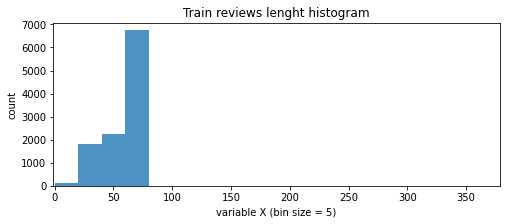

In [447]:
train_data_for_plot = [len(x) for x in x_train]
# fixed bin size
bins = np.arange(0, 100, 20) # fixed bin size
plt.xlim([min(train_data_for_plot)-5, max(train_data_for_plot)/4+5])
plt.hist(train_data_for_plot, bins=bins, alpha=0.8)
plt.title('Train reviews lenght histogram')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')
plt.show()

In [448]:
test_review_lens = Counter([len(i) for i in x_test])
print("Zero-length reviews: {}".format(test_review_lens[0]))
print("Maximum review length: {}".format(max(test_review_lens)))

Zero-length reviews: 0
Maximum review length: 788


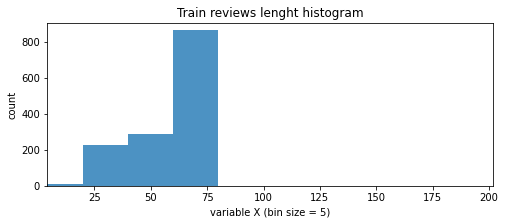

In [449]:
test_data_for_plot = [len(i) for i in x_test]
# fixed bin size
bins = np.arange(0, 100, 20) # fixed bin size
plt.xlim([min(test_data_for_plot)-5, max(test_data_for_plot)/4+5])
plt.hist(test_data_for_plot, bins=bins, alpha=0.8)
plt.title('Train reviews lenght histogram')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')
plt.show()

In [450]:
val_review_lens = Counter([len(i) for i in x_val])
print("Zero-length reviews: {}".format(val_review_lens[0]))
print("Maximum review length: {}".format(max(val_review_lens)))

Zero-length reviews: 0
Maximum review length: 825


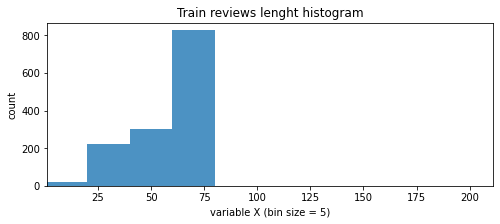

In [451]:
val_data_for_plot = [len(i) for i in x_val]
# fixed bin size
bins = np.arange(0, 100, 20) # fixed bin size
plt.xlim([min(val_data_for_plot)-5, max(val_data_for_plot)/4+5])
plt.hist(val_data_for_plot, bins=bins, alpha=0.8)
plt.title('Train reviews lenght histogram')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')
plt.show()

To decrease RNN training time the maximum review length will be cut to 100 words. For reviews shorter than 100, we'll pad with 0s. For reviews longer than 100, we can truncate them to the first 100 words.

### Encoding the words with provided vocabulary

In [452]:
def read_vocab():
    '''file format: "idx : word" '''
    filename = 'imdb.vocab'
    # path = os.getcwd() 
    word2id, id2word = {}, {}

    #with open(os.path.join(path, filename), 'r', encoding="utf8") as file:
    with open(filename, 'r', encoding="utf8") as file:
        for line in file:
            word = line.strip()
            idx = len(word2id)
            if word not in word2id:
                word2id[word] = idx
                id2word[idx] = word
    return word2id, id2word 

word2id, id2word  = read_vocab()


def encode_review(text, word2id):
    '''Converts text to numbers. Each word in the text is looked up in the dictionary
    and replaced by the corresponding number. If the word is not found - it is replaced with special vector.
    '''
    # '0' will enlist not only "the" token but also all not found words
    # we assume that our network will learn it
    return [word2id[word] if word in word2id else 0 for word in text]



In [453]:
train_reviews_ints = []
test_reviews_ints = []
val_reviews_ints = []

for each_review in x_train:
    train_reviews_ints.append(encode_review(each_review, word2id))
for each_review in x_test:
    test_reviews_ints.append(encode_review(each_review, word2id))
for each_review in x_val:
    val_reviews_ints.append(encode_review(each_review, word2id))    

In [454]:
len(train_reviews_ints), len(test_reviews_ints)

(30000, 3750)

### Padding short reviewes and cutting the lenght of the reviews

In [455]:
seq_len = 100

#padding with zeroes
prepared_train_review = np.zeros((len(train_reviews_ints), seq_len), dtype=int)
prepared_test_review = np.zeros((len(test_reviews_ints), seq_len), dtype=int)
prepared_val_review = np.zeros((len(val_reviews_ints), seq_len), dtype=int)

#cutting the lenght
for review_number, int_review in enumerate(train_reviews_ints):
    prepared_train_review[review_number, -len(int_review):] = np.array(int_review)[:seq_len]

for review_number, int_review in enumerate(test_reviews_ints):
    prepared_test_review[review_number, -len(int_review):] = np.array(int_review)[:seq_len]
    
for review_number, int_review in enumerate(val_reviews_ints):
    prepared_val_review[review_number, -len(int_review):] = np.array(int_review)[:seq_len]    

In [456]:
#prepared_val_review[:10,:100]

### Embeddings

###### Develop word2vec embeddings

https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

In [457]:
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [458]:
n_vocab = len(word2id)
n_embed = 100

glove_path = gensim.downloader.load('glove-twitter-100', return_path=True)
try:
    glove_model = gensim.models.keyedvectors.load_word2vec_format(glove_path)
except:
    glove_model = gensim.models.keyedvectors.load_word2vec_format(glove_path, binary=True)
# glove_model = api.load('word2vec-ruscorpora-300')  If we want to load without saving localy 

#loading the weights into torch Embeddings
weights = torch.FloatTensor(glove_model.vectors)
# Build nn.Embedding() layer
embedding = nn.Embedding.from_pretrained(weights) 

encoder = nn.Embedding(n_vocab, n_embed)
#encoder(torch.from_numpy(prepared_train_review[0]))

embedding.requires_grad_(False)


Embedding(1193514, 100)

## Data Loders and batching

In [459]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(prepared_train_review), torch.from_numpy(y_train.to_numpy()))
valid_data = TensorDataset(torch.from_numpy(prepared_val_review), torch.from_numpy(y_val.to_numpy()))
test_data = TensorDataset(torch.from_numpy(prepared_test_review), torch.from_numpy(y_test.to_numpy()))

# dataloaders
batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [460]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


## Training

In [461]:
# DEFINE THE LSTM MODEL
class CustomLSTM(nn.Module):
    #def __init__(self, input_sz, hidden_sz):
    def __init__(self, n_vocab, n_embed, n_hidden, n_output, n_layers, encoder, drop_p = 0.5):
        super().__init__()
        self.n_embed = n_embed        
        self.n_vocab = n_vocab     # number of unique words in vocabulary
        self.n_layers = n_layers   # number of LSTM layers 
        self.n_hidden = n_hidden   # number of hidden nodes in LSTM
        
        self.embedding = encoder
        
        self.dropout = nn.Dropout(drop_p)
        self.fc = nn.Linear(n_hidden, n_output)
        self.sigmoid = nn.Sigmoid()
        
        self.W = nn.Parameter(torch.Tensor(n_embed, n_hidden * 4))
        self.U = nn.Parameter(torch.Tensor(n_hidden, n_hidden * 4))
        self.bias = nn.Parameter(torch.Tensor(n_hidden * 4))
        self.init_weights()
                
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.n_hidden)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
         
    def forward(self, x, 
                init_states=None):
        
        x = self.embedding(x)    # (batch_size, seq_length, n_embed)

        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.n_hidden).to(x.device), 
                        torch.zeros(bs, self.n_hidden).to(x.device))
        else:
            h_t, c_t = init_states
         
        HS = self.n_hidden
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.W + h_t @ self.U + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        hidden_seq, (h_t, c_t)
        lstm_out, h = hidden_seq, (h_t, c_t)      # (batch_size, seq_length, n_hidden)
        lstm_out = self.dropout(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, self.n_hidden) # (batch_size*seq_length, n_hidden)
        fc_out = self.fc(lstm_out)                      # (batch_size*seq_length, n_output)
        sigmoid_out = self.sigmoid(fc_out)              # (batch_size*seq_length, n_output)
        sigmoid_out = sigmoid_out.view(batch_size, -1)  # (batch_size, seq_length*n_output)
        
        # extract only the output of the last output of the last element of the sequence
        sigmoid_last = sigmoid_out[:, -1]               # (batch_size, 1)
        
        return sigmoid_last, h
    
    def init_hidden (self, batch_size):  # initialize hidden weights (h,c) to 0
        
        device = "cuda" if torch.cuda.is_available() else "cpu"
        weights = next(self.parameters()).data
        h = (weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
             weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        
        return h

In [472]:
# Instansiate the model hyperparameters
n_vocab = len(word2id)
n_embed = 100
n_hidden = 50
n_output = 1   # 1 ("positive") or 0 ("negative")
n_layers = 2

net = CustomLSTM(n_vocab, n_embed, n_hidden, n_output, n_layers, encoder = encoder)

In [473]:
# Define Loss & Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.01)

In [474]:
#TRAIN THE NETWORK!
def train_lstm(net, n_epochs):
    train_losses = [None]
    val_losses = [None]
    print_every = 100
    step = 0
    clip = 5  # for gradient clip to prevent exploding gradient problem in LSTM/RNN
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    test_losses = []
    test_accuracies = []
    

    for epoch in range(n_epochs):
        train_lst = []
        val_lst = []
        h = net.init_hidden(batch_size)

        for inputs, labels in train_loader:
            step += 1
            inputs, labels = inputs.to(device), labels.to(device)

            # making requires_grad = False for the latest set of h
            h = tuple([each.data for each in h])   

            net.zero_grad()
            output, h = net(inputs)
            loss = criterion(output.squeeze(), labels.float().squeeze())
            loss.backward()
            nn.utils.clip_grad_norm(net.parameters(), clip)
            optimizer.step()

            if (step % print_every) == 0:            
                ######################
                ##### VALIDATION #####
                ######################
                net.eval()
                valid_losses = []
                v_h = net.init_hidden(batch_size)

                for v_inputs, v_labels in valid_loader:
                    v_inputs, v_labels = inputs.to(device), labels.to(device)

                    v_h = tuple([each.data for each in v_h])

                    v_output, v_h = net(v_inputs)
                    v_loss = criterion(v_output.squeeze(), v_labels.float().squeeze())
                    valid_losses.append(v_loss.item())

                print("Epoch: {}/{}".format((epoch+1), n_epochs),
                      "Step: {}".format(step),
                      "Training Loss: {:.4f}".format(loss.item()),
                      "Validation Loss: {:.4f}".format(np.mean(valid_losses)))
                
                train_lst.append(loss.item())
                val_lst.append(valid_losses[-1])
                net.train()
        
        
        train_losses.append(np.mean(train_lst))
        val_losses.append(np.mean(val_lst))
       
    
    return net, train_losses, val_losses

# Results 

In [ ]:
n_epochs = 10
net, train_losses, val_losses = train_lstm(net, n_epochs)

C:\Users\User\AppData\Local\Temp/ipykernel_85428/953447495.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(net.parameters(), clip)


Epoch: 1/10 Step: 100 Training Loss: 0.6527 Validation Loss: 0.6644
Epoch: 1/10 Step: 200 Training Loss: 0.5574 Validation Loss: 0.5349
Epoch: 1/10 Step: 300 Training Loss: 0.4886 Validation Loss: 0.3863
Epoch: 1/10 Step: 400 Training Loss: 0.4793 Validation Loss: 0.3837
Epoch: 1/10 Step: 500 Training Loss: 0.3519 Validation Loss: 0.3045


In [ ]:
# summarize history for loss
plt.rcParams["figure.figsize"] = (8,3)
plt.xlim([1, n_epochs])
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Model loss vs Epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
def test_results(net, fp = False):
    # Test the trained model on the test set
    net.eval()
    test_losses = []
    num_correct = 0
    test_h = net.init_hidden(batch_size)
    test_out = []
    test_labels = []

    for inputs, labels in test_loader:
        test_h = tuple([each.data for each in test_h])
        test_output, test_h = net(inputs)
        loss = criterion(test_output.squeeze(), labels.float().squeeze())
        test_losses.append(loss.item())

        preds = torch.round(test_output.squeeze())
        correct_tensor = preds.eq(labels.float().view_as(preds))
        correct = np.squeeze(correct_tensor.numpy())
        num_correct += np.sum(correct)
        if fp:
            for i in range(50):
                test_labels.append(labels.float()[i].item())
                test_out.append(1-preds.float()[i].item())
        else:
            for i in range(50):
                test_labels.append(labels.float()[i].item())
                test_out.append(preds.float()[i].item())
            
    print("Test Loss: {:.4f}".format(np.mean(test_losses)))
    print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))
    return  test_out, test_labels

test_out, test_labels = test_results(net)

In [ ]:
#ROC curve and calculate AUC for the test set
plt.rcParams["figure.figsize"] = (8,3)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
fpr, tpr, _ = metrics.roc_curve(np.array(test_out), np.array(test_labels))
auc = metrics.roc_auc_score(np.array(test_out),  np.array(test_labels))
plt.plot(fpr, tpr, label="Data ROC, AUC="+str(auc))
plt.title('ROC and ACU for the test set')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend(loc=4)
plt.show()

## second embedding

In [ ]:
n_vocab = len(word2id)

glove_path = gensim.downloader.load('word2vec-google-news-300', return_path=True)
try:
    glove_model = gensim.models.keyedvectors.load_word2vec_format(glove_path)
except:
    glove_model = gensim.models.keyedvectors.load_word2vec_format(glove_path, binary=True)
# glove_model = api.load('word2vec-ruscorpora-300')  If we want to load without saving localy 

#loading the weights into torch Embeddings
weights1 = torch.FloatTensor(glove_model.vectors)
# Build nn.Embedding() layer
embedding1 = nn.Embedding.from_pretrained(weights1) 

encoder1 = nn.Embedding(n_vocab, n_embed)
#encoder(torch.from_numpy(prepared_train_review[0]))

embedding.requires_grad_(False)

In [ ]:
net1 = CustomLSTM(n_vocab, n_embed, n_hidden, n_output, n_layers, encoder = encoder1)

In [ ]:
net1, train_losses1, val_losses1 = train_lstm(net1, n_epochs)

In [ ]:
#test_results(net1)

In [ ]:
# summarize history for loss
plt.rcParams["figure.figsize"] = (8,3)
plt.plot(train_losses1)
plt.plot(val_losses1)
plt.title('Model loss vs Epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
test_out1, test_labels1 = test_results(net1)

In [ ]:
#ROC curve and calculate AUC for the test set
plt.rcParams["figure.figsize"] = (8,3)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
fpr, tpr, _ = metrics.roc_curve(np.array(test_out1), np.array(test_labels1))
auc = metrics.roc_auc_score(np.array(test_out1),  np.array(test_labels1))
plt.plot(fpr, tpr, label="Data ROC, AUC="+str(auc))
plt.title('ROC and ACU for the test set')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend(loc=4)
plt.show()

# Conclusions

In [ ]:
#https://rguigoures.github.io/word2vec_pytorch/